In [2]:
import os, yaml, zipfile, shutil, torch, glob
from ultralytics import YOLO
from IPython.display import Image, display
from utils.create_data_yaml import create_data_yaml_from_set_and_classes
from utils.get_notebook_path import get_notebook_path
from utils.clear_folder import clear_folder
from utils.data_cleaning import data_cleaning
from utils.preview_labels import preview_labels
from utils.analyze_imgsz import analyze_imgsz
from utils.data_preprocess import data_preprocess

# Introduction

This notebook uses [Ultralytics](https://docs.ultralytics.com/) to train YOLO11, YOLOv8, or YOLOv5 object detection models with a custom dataset.

**Verify NVIDIA GPU Availability**

In [ ]:
!nvidia-smi

**Option 1. Upload the Dataset**

Upload the `data.zip` (Export from Label studio) to the root folder.

## 2. Split images into train and validation folders
Next, we'll unzip `data.zip` and create some folders to hold the images.

In [ ]:
# Extract custom_data (required)
extract_dir = "dataset/custom_data"
zip_path = "dataset/data.zip"

clear_folder(extract_dir)

if os.path.exists(zip_path):
    clear_folder(extract_dir)
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print("dataset/set.zip not found; skipping set extraction.")

# Extract set (optional)
set_extract_dir = "dataset/set"
set_zip_path = "dataset/set.zip"

if os.path.exists(set_zip_path):
    clear_folder(set_extract_dir)
    os.makedirs(set_extract_dir, exist_ok=True)
    with zipfile.ZipFile(set_zip_path, 'r') as zip_ref:
        zip_ref.extractall(set_extract_dir)
else:
    print("dataset/set.zip not found; skipping set extraction.")

Now we will build the Ultralytics folder structure under `data/` by merging:

- `dataset/set/` (from `set.zip`): copy `train` and `valid` (and optionally `test`) into `data/`.
- `dataset/custom_data/`: split 80/20 (configurable) and append into `data/train` and `data/validation`.

The script avoids filename collisions and pairs each image with its corresponding label.

In [ ]:
clear_folder("data")
!python -m utils.merge_datasets --set_dir dataset/set --custom_dir dataset/custom_data --data_dir data --train_pct 0.9 --include_test

# 4.&nbsp;Configure Training


There's one last step before training: create `data.yaml`. We'll take the class names (`names` and `nc`) directly from `dataset/set/data.yaml`, and point `train`/`val` to our merged `data/` folders.

In [ ]:
path_to_set_yaml = 'dataset/set/data.yaml'
path_to_classes_txt = 'dataset/custom_data/classes.txt'
path_to_data_yaml = 'data.yaml'

create_data_yaml_from_set_and_classes(path_to_set_yaml, path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
with open("data.yaml", "r") as f:
    print(f.read())


# 5.&nbsp;Train Model

## 5.1 Training Parameters

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy. 

Example: [check it out here to get a sense of their speed accuracy](https://youtu.be/_WKS4E9SmkA). 
By default, `yolo11s.pt` will be used as the starting point.

We can also train with YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**
In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. 

In our case we will use 60 epochs. 
If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**
Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. 
YOLO models are typically trained and inferenced at a 640x640 resolution. 

We can choose to lower the resolution to 480x480 for better model performance


model = Specifies the model to use
epochs = Specifies the number of training epochs
imgsz = Specifies the resolution of the images

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detectada")

In [ ]:
data_cleaning()

In [ ]:
clear_folder("previews/")
preview_labels(data_path="data")

In [ ]:
analyze_imgsz()

In [ ]:
PREPROCESSED_DATA_FOLDER = "data_preprocessed"

clear_folder(PREPROCESSED_DATA_FOLDER)
data_preprocess(datap_path=PREPROCESSED_DATA_FOLDER)
preview_labels(data_path=PREPROCESSED_DATA_FOLDER)

In [7]:
clear_folder("runs/detect/train")

model = YOLO("yolo11s.pt")

model.train(
    data="data.yaml",
    model="yolo11s.pt",
    epochs=60,
    imgsz=512,
    batch=16,
    workers=8,
    amp=True,

    # AUGMENTATION — VALIDADO PARA YOLO11
    hsv_h=0.015,       # variación ligera de tono
    hsv_s=0.7,         # saturación fuerte (útil en exteriores)
    hsv_v=0.4,         # variación de brillo moderada
    degrees=5.0,       # rotación suave (personas no deben rotarse mucho)
    translate=0.10,    # desplazamiento leve
    scale=0.50,        # zoom in/out moderado
    shear=1.5,         # deformación suave
    perspective=0.0005,# perspectiva muy ligera
    flipud=0.0,        # NO voltear verticalmente personas
    fliplr=0.5,        # flip horizontal sí es natural
    mosaic=1.0,        # mosaico activado (muy útil)
    mixup=0.10,        # mezcla suave
    copy_paste=0.0,    # no recomendado para humanos
    erasing=0.4,       # borrado aleatorio útil, sin exagerar
    crop_fraction=1.0, # 1.0 = sin recorte agresivo
)



WARNING 'crop_fraction' is deprecated and will be removed in the future.
Ultralytics 8.3.228  Python-3.13.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000025F3105FE00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

The training algorithm will parse the images in the training and validation directories and then start training the model. 

At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

# 6.&nbsp;Test Model
The commands below run the model on the images in the validation folder and then display the results for the first 10 images.


image 1/1000 d:\Todo\Documentos\Santiago\3_Trabajo Profesional\Full-Stack-Projects\yolo-train-routes-optimization\data\validation\images\000000000113_jpg.rf.8b1fa8a22e4aa85514ace44e034aa923.jpg: 512x512 3 persons, 20.7ms
image 2/1000 d:\Todo\Documentos\Santiago\3_Trabajo Profesional\Full-Stack-Projects\yolo-train-routes-optimization\data\validation\images\000000000927_jpg.rf.b30d4f4c68c9ec1a1035beef5cf3cf8d.jpg: 512x512 10 persons, 20.1ms
image 3/1000 d:\Todo\Documentos\Santiago\3_Trabajo Profesional\Full-Stack-Projects\yolo-train-routes-optimization\data\validation\images\000000001424_jpg.rf.fad37bb40e5fecb6d0d3f44c1ccee68b.jpg: 512x512 4 persons, 20.0ms
image 4/1000 d:\Todo\Documentos\Santiago\3_Trabajo Profesional\Full-Stack-Projects\yolo-train-routes-optimization\data\validation\images\000000001941_jpg.rf.566f57a96d78b3a7febfb2692cc6aa67.jpg: 512x512 11 persons, 19.5ms
image 5/1000 d:\Todo\Documentos\Santiago\3_Trabajo Profesional\Full-Stack-Projects\yolo-train-routes-optimization

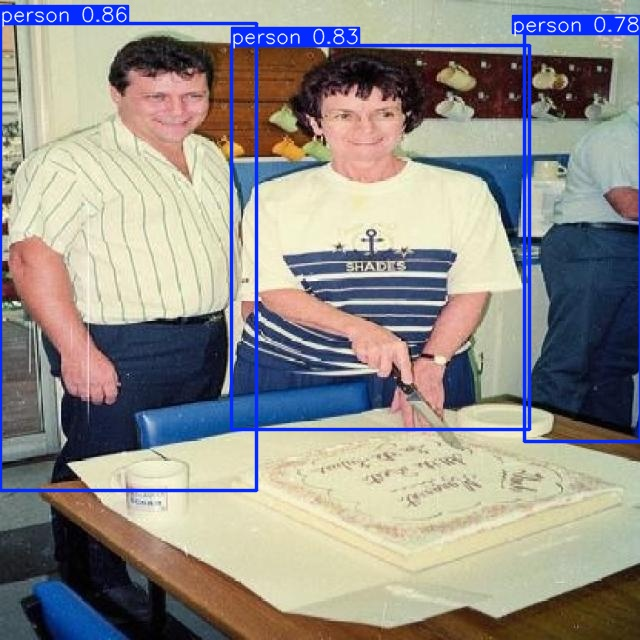

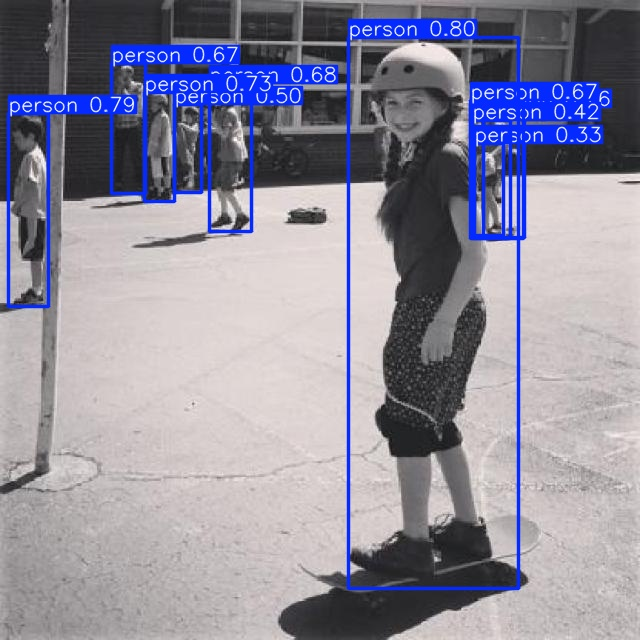

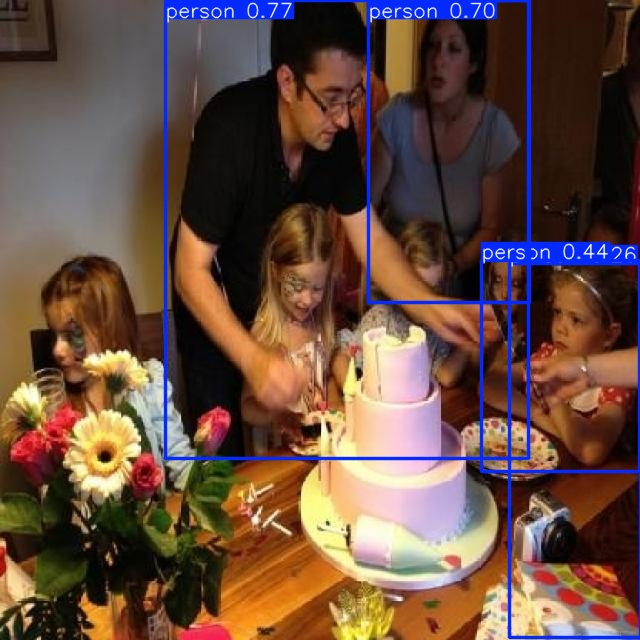

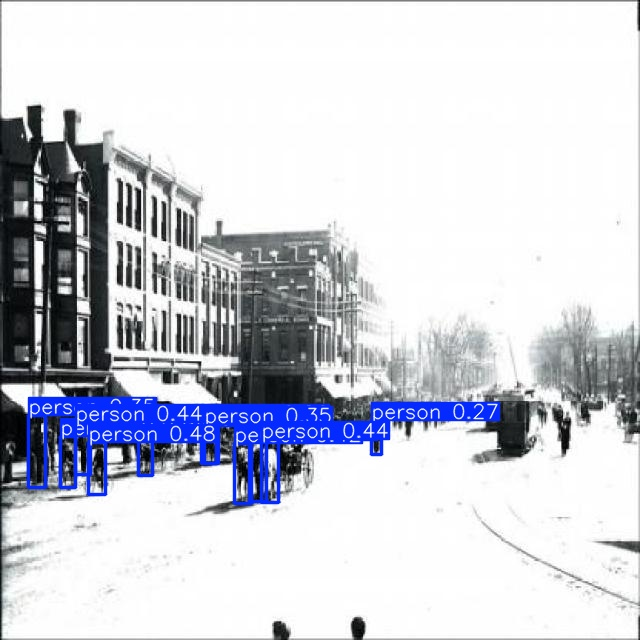

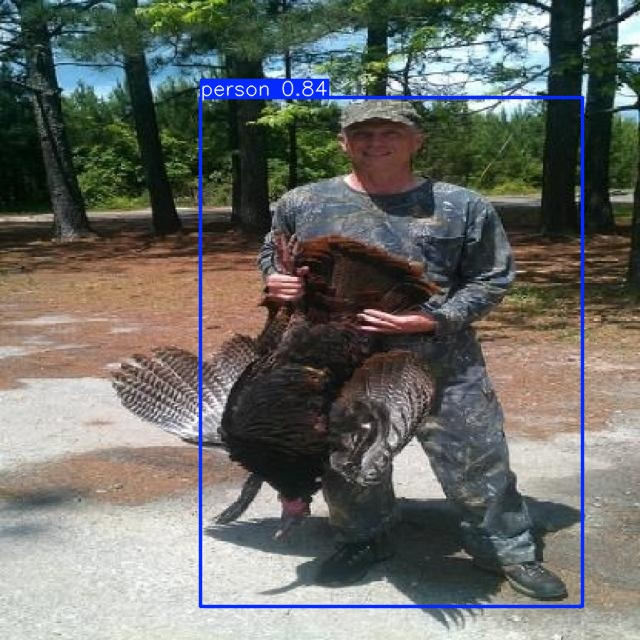

In [4]:
clear_folder("runs/detect/predict")

model = YOLO("runs/detect/train/weights/best.pt")

results = model.predict(
    source="data/validation/images",  
    save=True,
    show=False,
    conf=0.25
)

for image_path in glob.glob(f'runs/detect/predict/*.jpg')[:5]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model should draw a box around each object of interest in each image.

# 7.&nbsp;Deploy Model

## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`, and also adds the training results for reference.

In [5]:
#clear_folder("my_model")

base_dir = get_notebook_path()
train_dir = os.path.join(base_dir, "runs", "detect", "train")
output_dir = os.path.join(base_dir, "my_model")

os.makedirs(output_dir, exist_ok=True)

shutil.copy(os.path.join(train_dir, "weights", "best.pt"), os.path.join(output_dir, "my_model.pt"))
shutil.copytree(train_dir, os.path.join(output_dir, "train"), dirs_exist_ok=True)


'D:\\Todo\\Documentos\\Santiago\\3_Trabajo Profesional\\Full-Stack-Projects\\yolo-train-routes-optimization\\my_model\\train'

# 8. Using the model

In [6]:
!python utils/yolo_detect.py --model my_model/my_model.pt --source usb1 --resolution 1280x720

Average pipeline FPS: 18.81


In [5]:
!python utils/yolo_detect.py --model my_model/my_model.pt --source assets/video4.mp4 --resolution 1280x720

Reached end of the video file. Exiting program.
Average pipeline FPS: 34.94
